In [1]:
%matplotlib inline
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
from scipy import stats as st
from scipy.optimize import minimize
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from sklearn.mixture import GaussianMixture as GMM

In [2]:
energy_data = pd.read_csv('energy_dataset.csv', error_bad_lines=False)
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
energy_data.isna().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [4]:
energy_data_subsample = energy_data[['generation hydro water reservoir', 'generation wind onshore', 'generation fossil oil']]
energy_data_subsample

,generation hydro water reservoir,generation wind onshore,generation fossil oil
0,1899.0,6378.0,162.0
1,1658.0,5890.0,158.0
2,1371.0,5461.0,157.0
3,779.0,5238.0,160.0
4,720.0,4935.0,156.0
...,...,...,...
35059,4836.0,3113.0,178.0
35060,3931.0,3288.0,174.0
35061,2831.0,3503.0,168.0
35062,2068.0,3586.0,163.0


In [5]:
energy_data_subsample.mean()
energy_data_subsample_clear = energy_data_subsample.fillna(energy_data.mean())

In [6]:
energy_data_subsample_clear.isna().sum()

generation hydro water reservoir    0
generation wind onshore             0
generation fossil oil               0
dtype: int64

In [9]:
n = len(energy_data_subsample_clear.index)

In [10]:
sns.set_theme(style="whitegrid")

# Generation hydro water reservoir

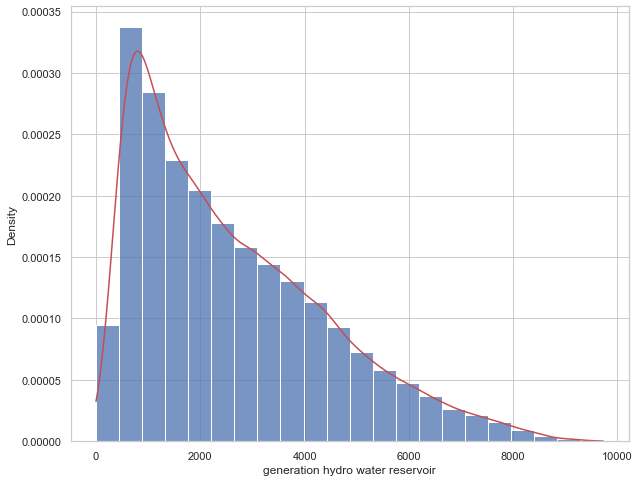

In [11]:
plt.figure(figsize=(10, 8))
ghwr_data = energy_data_subsample_clear['generation hydro water reservoir']

kernel = st.gaussian_kde(ghwr_data)
print(kernel)

min_amount, max_amount = ghwr_data.min(), ghwr_data.max()

x = np.linspace(min_amount, max_amount, len(ghwr_data))

kde_values = kernel(x)

sns.histplot(ghwr_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [12]:
ghwr_descr = ghwr_data.describe()

print(ghwr_descr)

count    35064.000000
mean      2605.114735
std       1834.728624
min          0.000000
25%       1078.000000
50%       2165.000000
75%       3756.250000
max       9728.000000
Name: generation hydro water reservoir, dtype: float64


In [13]:
quant = ghwr_data.quantile([.1, .25, .5, .75, .95])
print(quant)

0.10     622.00
0.25    1078.00
0.50    2165.00
0.75    3756.25
0.95    6234.00
Name: generation hydro water reservoir, dtype: float64


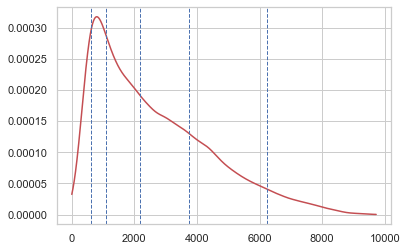

In [14]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

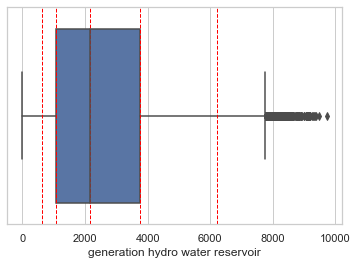

In [15]:
ax = sns.boxplot(x=ghwr_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

In [16]:
from fitter import Fitter, get_common_distributions, get_distributions

,sumsquare_error,aic,bic,kl_div
gamma,9.355688e-08,1979.246863,-934411.109814,inf
chi2,1.356484e-07,2030.470678,-921384.949913,inf
exponpow,1.942141e-07,2009.039511,-908800.651885,inf
rayleigh,2.740004e-07,2032.523359,-896743.199635,inf
lognorm,2.861937e-07,1997.841008,-895206.074193,inf


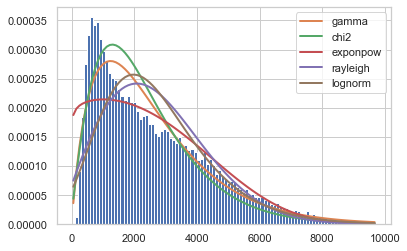

In [17]:
# 'chi', 'chi2', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'
f1 = Fitter(ghwr_data, distributions=get_common_distributions())

f1.fit()
f1.summary()


In [18]:
f1.get_best(method = 'sumsquare_error')

{'gamma': {'a': 1.9054548298156626,
  'loc': -0.9829232271899719,
  'scale': 1367.7037507953773}}

,sumsquare_error,aic,bic,kl_div
exponnorm,4.166661e-08,1974.205076,-962773.308814,inf
johnsonsb,4.468758e-08,2006.017247,-960308.520772,inf
fatiguelife,7.819447e-08,1978.076566,-940700.561508,inf
erlang,9.355688e-08,1979.246881,-934411.107161,inf
invgauss,1.038598e-07,1988.652384,-930747.877839,inf


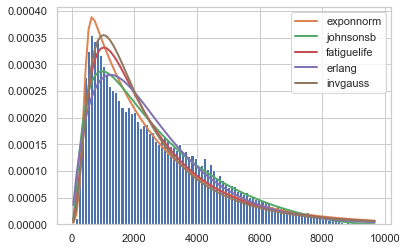

In [19]:
f2 = Fitter(ghwr_data, distributions=['chi', 'erlang', 'exponnorm','f', 'fatiguelife', 'invgamma', 'invgauss', 'johnsonsb'])
f2.fit()
f2.summary()

In [20]:
f2.get_best(method = 'sumsquare_error')

{'exponnorm': {'K': 16.802742105507946,
  'loc': 376.30328390667466,
  'scale': 132.64570643216751}}

## Maximum likelihood and Least squares method

In [22]:
params_ml_ghwr_gamma = st.gamma.fit(ghwr_data)

In [23]:
def loss_for_least_squares_gamma(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_gamma = least_squares(loss_for_least_squares_gamma, (1.0, 1.0, 1.0))['x']

In [24]:
print(f'Maximum likelihood results: {params_ml_ghwr_gamma}')
print(f'Least squares method results: {params_ls_ghwr_gamma}')

Maximum likelihood results: (1.9054548298156626, -0.9829232271899719, 1367.7037507953773)
Least squares method results: [   1.884242    -84.44739034 1453.81821144]


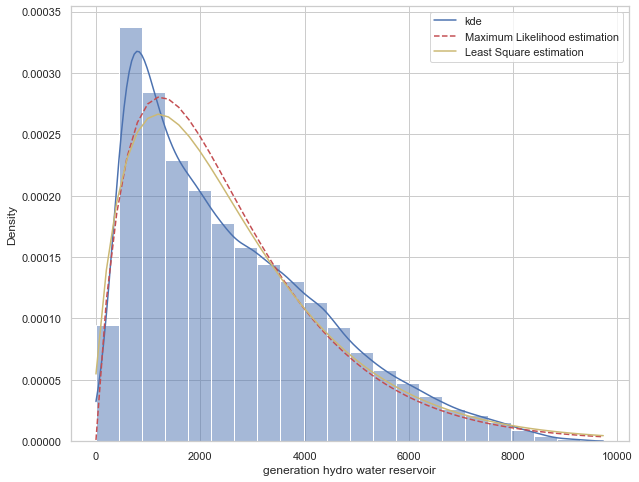

In [25]:
plt.figure(figsize=(10, 8))

sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_gamma = st.gamma.pdf(x, *params_ml_ghwr_gamma) 
pdf_ls_ghwr_gamma = st.gamma.pdf(x, *params_ls_ghwr_gamma)

plt.plot(x, pdf_ml_ghwr_gamma, 'r--')
plt.plot(x, pdf_ls_ghwr_gamma, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

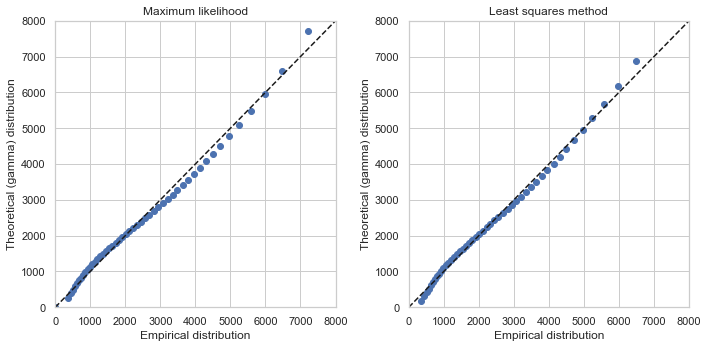

In [26]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)

qn_gamma_ml = st.gamma.ppf(percs / 100.0, *params_ml_ghwr_gamma)
qn_gamma_ls = st.gamma.ppf(percs / 100.0, *params_ls_ghwr_gamma)

ax1.plot(qn_first, qn_gamma_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (gamma) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.plot(qn_first, qn_gamma_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (gamma) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)

plt.tight_layout()

In [27]:
ks_ml = st.kstest(ghwr_data, 'gamma', params_ml_ghwr_gamma)
cm_ml = scipy.stats.cramervonmises(ghwr_data, 'gamma', params_ml_ghwr_gamma)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.04046992856341916, pvalue=2.4537023783081662e-50)
CramerVonMisesResult(statistic=19.638326499796747, pvalue=8.98746854716137e-09)


In [28]:
ks_ls = st.kstest(ghwr_data, 'gamma', params_ls_ghwr_gamma)
cm_ls = scipy.stats.cramervonmises(ghwr_data, 'gamma', params_ls_ghwr_gamma)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.03219478521076183, pvalue=5.207723623732955e-32)
CramerVonMisesResult(statistic=10.995181182770269, pvalue=2.222300121701437e-10)


In [29]:
params_ml_ghwr_exponnorm = st.exponnorm.fit(ghwr_data)

In [30]:
def loss_for_least_squares_exponnorm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.exponnorm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_exponnorm = least_squares(loss_for_least_squares_exponnorm, (1.0, 1.0, 1.0))['x']

In [31]:
print(f'Maximum likelihood results: {params_ml_ghwr_exponnorm}')
print(f'Least squares method results: {params_ls_ghwr_exponnorm}')

Maximum likelihood results: (16.802742105507946, 376.30328390667466, 132.64570643216751)
Least squares method results: [  3.71677513 665.74777739 541.81509741]


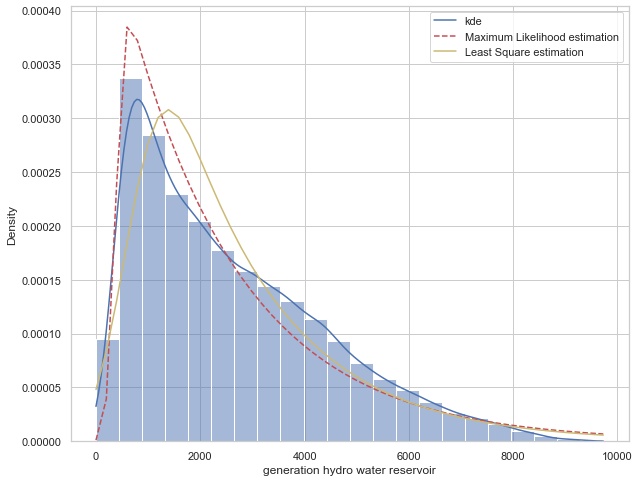

In [32]:
plt.figure(figsize=(10, 8))
sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_exponnorm = st.exponnorm.pdf(x, *params_ml_ghwr_exponnorm) 
pdf_ls_ghwr_exponnorm = st.exponnorm.pdf(x, *params_ls_ghwr_exponnorm)

plt.plot(x, pdf_ml_ghwr_exponnorm, 'r--')
plt.plot(x, pdf_ls_ghwr_exponnorm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

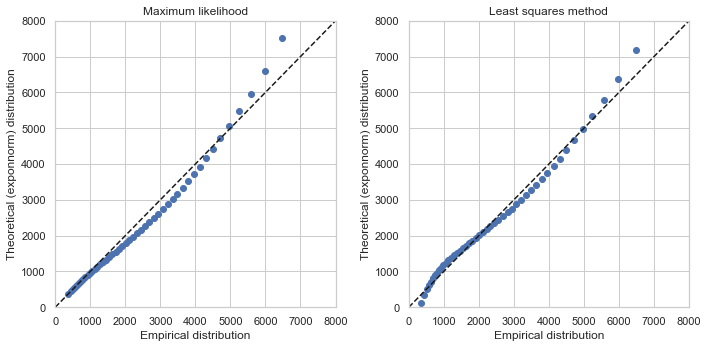

In [34]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)

qn_exponnorm_ml = st.exponnorm.ppf(percs / 100.0, *params_ml_ghwr_exponnorm)
qn_exponnorm_ls = st.exponnorm.ppf(percs / 100.0, *params_ls_ghwr_exponnorm)

ax1.plot(qn_first, qn_exponnorm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (exponnorm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.plot(qn_first, qn_exponnorm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (exponnorm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)

plt.tight_layout()

In [35]:
ks_ml = st.kstest(ghwr_data, 'exponnorm', params_ml_ghwr_exponnorm)
cm_ml = scipy.stats.cramervonmises(ghwr_data, 'exponnorm', params_ml_ghwr_exponnorm)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.0534956127426236, pvalue=1.1792212620214364e-87)
CramerVonMisesResult(statistic=36.794396265866105, pvalue=1.8800798251561446e-08)


In [36]:
ks_ls = st.kstest(ghwr_data, 'exponnorm', params_ls_ghwr_exponnorm)
cm_ls = scipy.stats.cramervonmises(ghwr_data, 'exponnorm', params_ls_ghwr_exponnorm)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.055852796113656206, pvalue=1.6228765279679295e-95)
CramerVonMisesResult(statistic=30.12333733635556, pvalue=6.486261527882675e-09)


In [37]:
params_ml_ghwr_johnsonsb = st.johnsonsb.fit(ghwr_data)

In [39]:
def loss_for_least_squares_johnsonsb(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(ghwr_data, q)
    quantiles_approx = st.johnsonsb.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_johnsonsb = least_squares(loss_for_least_squares_johnsonsb, (1.0, 1.0, 1.0, 1.0))['x']

In [40]:
print(f'Maximum likelihood results: {params_ml_ghwr_johnsonsb}')
print(f'Least squares method results: {params_ls_ghwr_johnsonsb}')

Maximum likelihood results: (1.1932420069028198, 0.9242514238282165, -4.449609489155438, 10054.841859706612)
Least squares method results: [8.34094041e-01 7.58374913e-01 1.43944003e+02 8.04757138e+03]


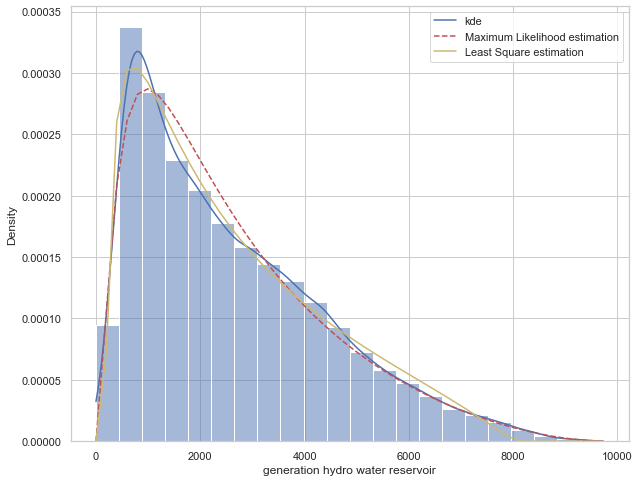

In [41]:
plt.figure(figsize=(10, 8))

sns.histplot(ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_johnsonsb = st.johnsonsb.pdf(x, *params_ml_ghwr_johnsonsb) 
pdf_ls_ghwr_johnsonsb = st.johnsonsb.pdf(x, *params_ls_ghwr_johnsonsb)

plt.plot(x, pdf_ml_ghwr_johnsonsb, 'r--')
plt.plot(x, pdf_ls_ghwr_johnsonsb, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

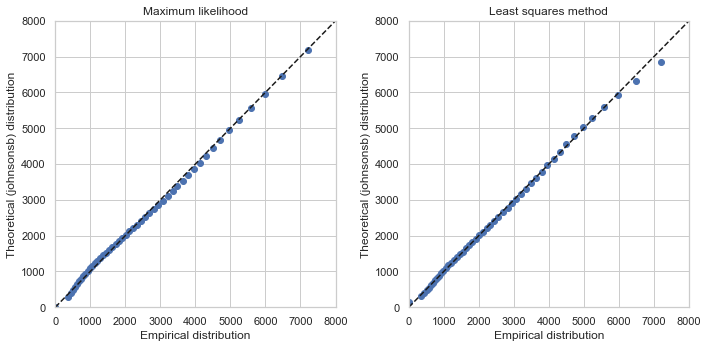

In [42]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)

qn_johnsonsb_ml = st.johnsonsb.ppf(percs / 100.0, *params_ml_ghwr_johnsonsb)
qn_johnsonsb_ls = st.johnsonsb.ppf(percs / 100.0, *params_ls_ghwr_johnsonsb)

ax1.plot(qn_first, qn_johnsonsb_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (johnsonsb) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.plot(qn_first, qn_johnsonsb_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (johnsonsb) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)

plt.tight_layout()

In [43]:
ks_ml = st.kstest(ghwr_data, 'johnsonsb', params_ml_ghwr_johnsonsb)
cm_ml = scipy.stats.cramervonmises(ghwr_data, 'johnsonsb', params_ml_ghwr_johnsonsb)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.02748061964248308, pvalue=1.946725173137951e-23)
CramerVonMisesResult(statistic=6.8720532546415605, pvalue=1.3568735024449552e-10)


In [44]:
ks_ls = st.kstest(ghwr_data, 'johnsonsb', params_ls_ghwr_johnsonsb)
cm_ls = scipy.stats.cramervonmises(ghwr_data, 'johnsonsb', params_ls_ghwr_johnsonsb)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.010744134214794698, pvalue=0.0006054748989965183)
CramerVonMisesResult(statistic=1.1567730682046728, pvalue=0.0010607926005496982)


### Transformation

#### Trimming

In [135]:
def cut_ends(feature):

    q_1, q_3 = np.percentile(feature, [25, 75])
    dfce = q_3 - q_1
    bottom_border, top_border = q_1 - 1.5*dfce, q_3 + 1.5*dfce
    feature = feature[feature > bottom_border]
    feature = feature[feature < top_border]

    return feature

In [153]:
cutting_ghwr_data = cut_ends(ghwr_data)

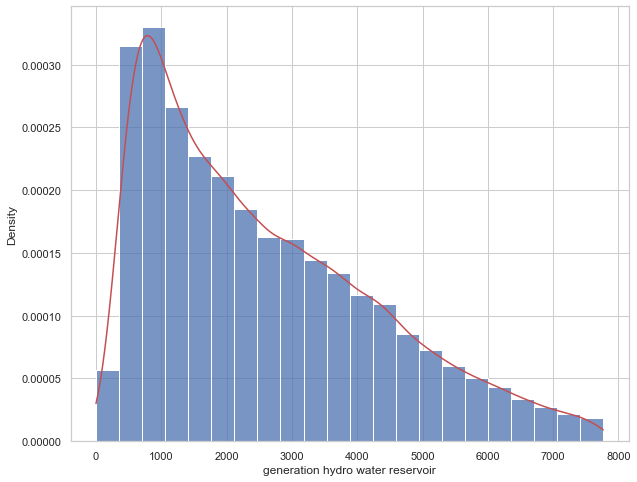

In [147]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_ghwr_data)
print(kernel)

min_amount, max_amount = cutting_ghwr_data.min(), cutting_ghwr_data.max()
x = np.linspace(min_amount, max_amount, len(cutting_ghwr_data))

kde_values = kernel(x)

sns.histplot(cutting_ghwr_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [154]:
params_ml_ghwr_gamma = st.gamma.fit(cutting_ghwr_data)

In [155]:
def loss_for_least_squares_gamma(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(cutting_ghwr_data, q)
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_gamma = least_squares(loss_for_least_squares_gamma, (1.0, 1.0, 1.0))['x']


In [156]:
print(f'Maximum likelihood results: {params_ml_ghwr_gamma}')
print(f'Least squares method results: {params_ls_ghwr_gamma}')

Maximum likelihood results: (1.953736402839028, -1.1217648183711937, 1305.2909943333118)
Least squares method results: [   1.98850954 -119.44008003 1370.97962694]


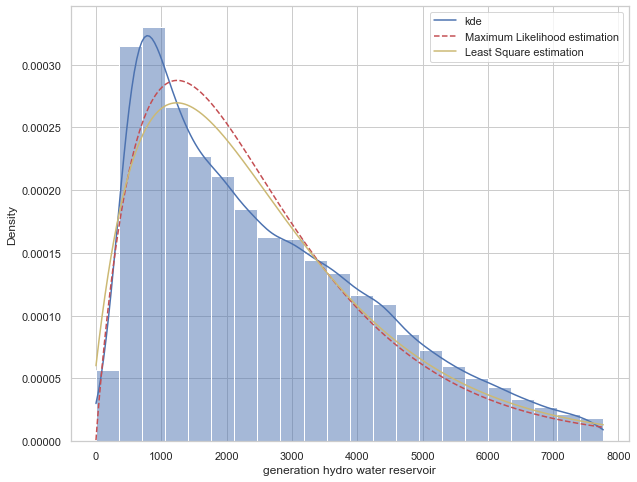

In [157]:
plt.figure(figsize=(10, 8))

sns.histplot(cutting_ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_gamma = st.gamma.pdf(x, *params_ml_ghwr_gamma) 
pdf_ls_ghwr_gamma = st.gamma.pdf(x, *params_ls_ghwr_gamma)

plt.plot(x, pdf_ml_ghwr_gamma, 'r--')
plt.plot(x, pdf_ls_ghwr_gamma, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

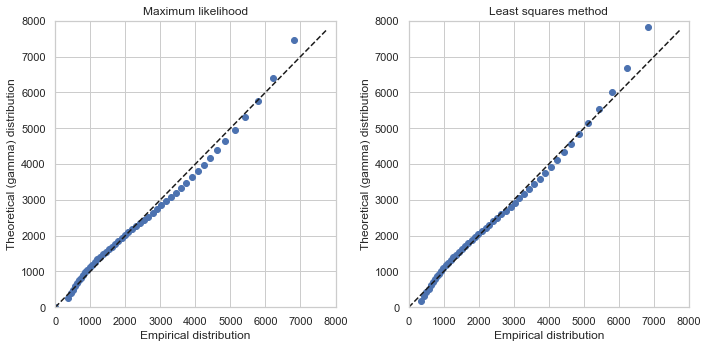

In [158]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data, percs)

qn_gamma_ml = st.gamma.ppf(percs / 100.0, *params_ml_ghwr_gamma)
qn_gamma_ls = st.gamma.ppf(percs / 100.0, *params_ls_ghwr_gamma)

ax1.plot(qn_first, qn_gamma_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (gamma) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.plot(qn_first, qn_gamma_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (gamma) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)

plt.tight_layout()

In [159]:
ks_ml = st.kstest(cutting_ghwr_data, 'gamma', params_ml_ghwr_gamma)
cm_ml = scipy.stats.cramervonmises(cutting_ghwr_data, 'gamma', params_ml_ghwr_gamma)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)


Maximum likelihood
KstestResult(statistic=0.04072663932167875, pvalue=1.779249927757078e-50)
CramerVonMisesResult(statistic=22.055314256283165, pvalue=4.431098377111198e-09)


In [160]:
ks_ls = st.kstest(cutting_ghwr_data, 'gamma', params_ls_ghwr_gamma)
cm_ls = scipy.stats.cramervonmises(cutting_ghwr_data, 'gamma', params_ls_ghwr_gamma)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.03406468845285843, pvalue=1.9391458869833093e-35)
CramerVonMisesResult(statistic=12.484477512421885, pvalue=2.193662140825836e-09)


In [161]:
params_ml_ghwr_exponnorm = st.exponnorm.fit(cutting_ghwr_data)

In [162]:
def loss_for_least_squares_exponnorm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(cutting_ghwr_data, q)
    quantiles_approx = st.exponnorm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_exponnorm = least_squares(loss_for_least_squares_exponnorm, (1.0, 1.0, 1.0))['x']


In [163]:
print(f'Maximum likelihood results: {params_ml_ghwr_exponnorm}')
print(f'Least squares method results: {params_ls_ghwr_exponnorm}')

Maximum likelihood results: (15.982543588396112, 380.9267003996439, 135.65712893542826)
Least squares method results: [  3.42446525 690.40203319 566.76172343]


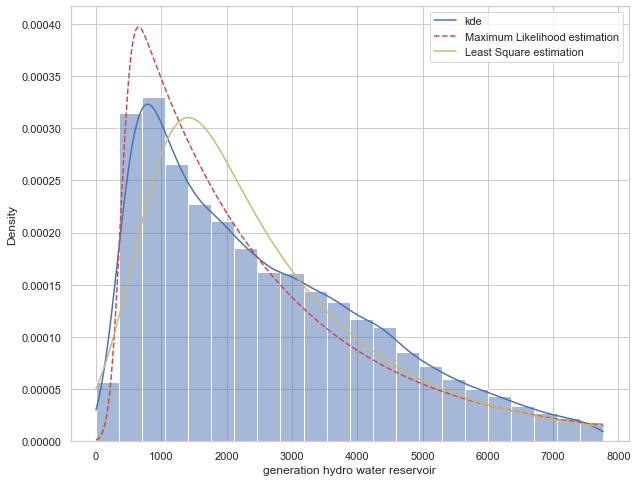

In [164]:
plt.figure(figsize=(10, 8))
sns.histplot(cutting_ghwr_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_exponnorm = st.exponnorm.pdf(x, *params_ml_ghwr_exponnorm) 
pdf_ls_ghwr_exponnorm = st.exponnorm.pdf(x, *params_ls_ghwr_exponnorm)

plt.plot(x, pdf_ml_ghwr_exponnorm, 'r--')
plt.plot(x, pdf_ls_ghwr_exponnorm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

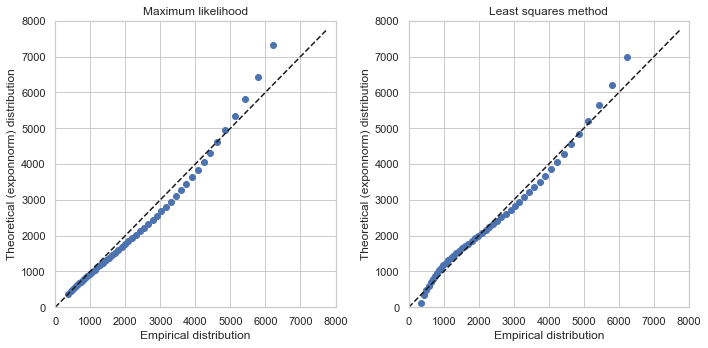

In [165]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data, percs)

qn_exponnorm_ml = st.exponnorm.ppf(percs / 100.0, *params_ml_ghwr_exponnorm)
qn_exponnorm_ls = st.exponnorm.ppf(percs / 100.0, *params_ls_ghwr_exponnorm)

ax1.plot(qn_first, qn_exponnorm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (exponnorm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 8000)
ax1.set_ylim(0, 8000)

ax2.plot(qn_first, qn_exponnorm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (exponnorm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 8000)
ax2.set_ylim(0, 8000)

plt.tight_layout()

#### Jeo-Johnson

In [168]:
ghwr_data_tr = st.yeojohnson(ghwr_data, lmbda=0)

cutting_ghwr_data_tr = cut_ends(ghwr_data_tr)

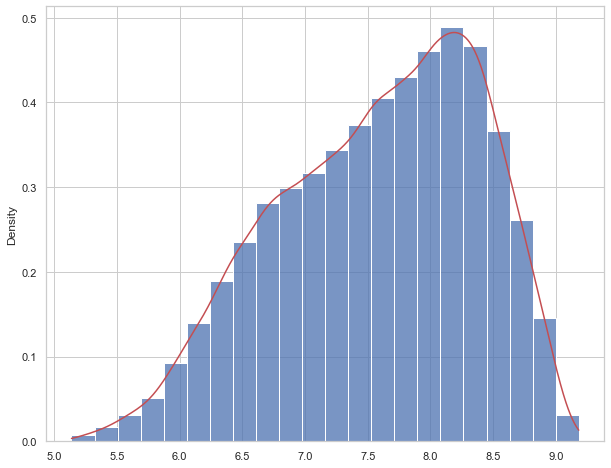

In [169]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_ghwr_data_tr)
print(kernel)

min_amount, max_amount = cutting_ghwr_data_tr.min(), cutting_ghwr_data_tr.max()
x = np.linspace(min_amount, max_amount, len(cutting_ghwr_data_tr))

kde_values = kernel(x)

sns.histplot(cutting_ghwr_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [170]:
params_ml_ghwr_norm = st.norm.fit(cutting_ghwr_data_tr)

In [171]:
def loss_for_least_squares_norm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(cutting_ghwr_data_tr, q)
    quantiles_approx = st.norm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_ghwr_norm = least_squares(loss_for_least_squares_norm, (1.0, 1.0))['x']

In [172]:
print(f'Maximum likelihood results: {params_ml_ghwr_norm}')
print(f'Least squares method results: {params_ls_ghwr_norm}')

Maximum likelihood results: (7.5820586901720795, 0.8060902064495766)
Least squares method results: [7.60255094 0.84759705]


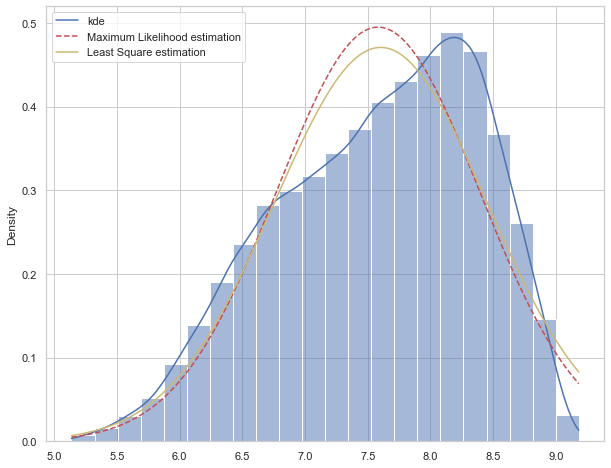

In [173]:
plt.figure(figsize=(10, 8))

sns.histplot(cutting_ghwr_data_tr, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')

pdf_ml_ghwr_norm = st.norm.pdf(x, *params_ml_ghwr_norm) 
pdf_ls_ghwr_norm = st.norm.pdf(x, *params_ls_ghwr_norm)

plt.plot(x, pdf_ml_ghwr_norm, 'r--')
plt.plot(x, pdf_ls_ghwr_norm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

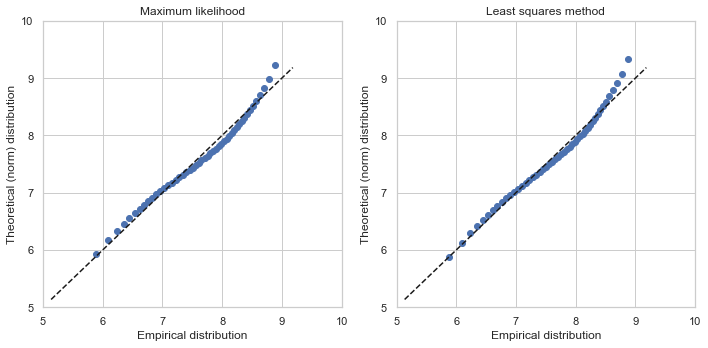

In [174]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_ghwr_data_tr, percs)

qn_norm_ml = st.norm.ppf(percs / 100.0, *params_ml_ghwr_norm)
qn_norm_ls = st.norm.ppf(percs / 100.0, *params_ls_ghwr_norm)

ax1.plot(qn_first, qn_norm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (norm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(5, 10)
ax1.set_ylim(5, 10)

ax2.plot(qn_first, qn_norm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (norm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(5, 10)
ax2.set_ylim(5, 10)

plt.tight_layout()

In [175]:
ks_ml = st.kstest(cutting_ghwr_data_tr, 'norm', params_ml_ghwr_norm)
cm_ml = scipy.stats.cramervonmises(cutting_ghwr_data_tr, 'norm', params_ml_ghwr_norm)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)


ks_ls = st.kstest(cutting_ghwr_data_tr, 'norm', params_ls_ghwr_norm)
cm_ls = scipy.stats.cramervonmises(cutting_ghwr_data_tr, 'norm', params_ls_ghwr_norm)

print('Least squares')
print(ks_ls)
print(cm_ls)

Maximum likelihood
KstestResult(statistic=0.06163853526953866, pvalue=3.2344910154667014e-116)
CramerVonMisesResult(statistic=41.65663732800192, pvalue=1.9370556048059484e-08)
Least squares
KstestResult(statistic=0.04552296640372988, pvalue=1.4565641584662955e-63)
CramerVonMisesResult(statistic=25.545107204105452, pvalue=4.283933874305035e-09)


---

# Generation wind onshore

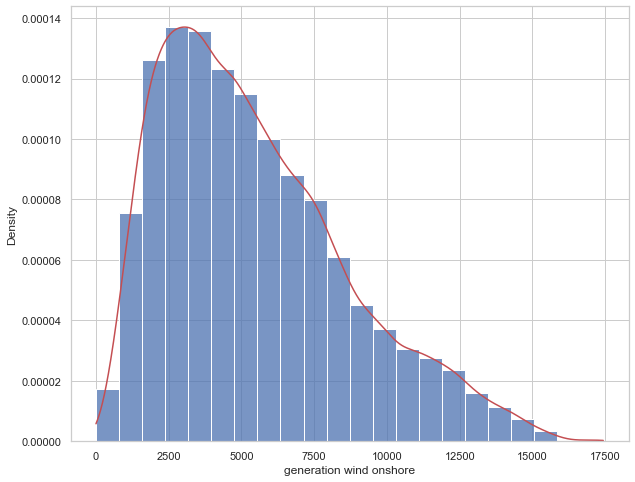

In [176]:
plt.figure(figsize=(10, 8))
gwo_data = energy_data_subsample_clear['generation wind onshore']

kernel = st.gaussian_kde(gwo_data)
print(kernel)

min_amount, max_amount = gwo_data.min(), gwo_data.max()
x = np.linspace(min_amount, max_amount, len(gwo_data))

kde_values = kernel(x)

sns.histplot(gwo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')
plt.plot(x, kde_values, color='r')

In [177]:
gwo_descr = gwo_data.describe()

print(gwo_descr)

count    35064.000000
mean      5464.479769
std       3212.866588
min          0.000000
25%       2933.750000
50%       4850.500000
75%       7397.000000
max      17436.000000
Name: generation wind onshore, dtype: float64


In [178]:
quant = gwo_data.quantile([.1, .25, .5, .75, .95])
print(quant)

0.10     1809.00
0.25     2933.75
0.50     4850.50
0.75     7397.00
0.95    11874.85
Name: generation wind onshore, dtype: float64


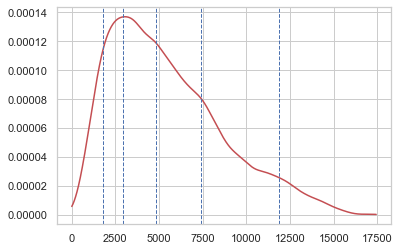

In [179]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

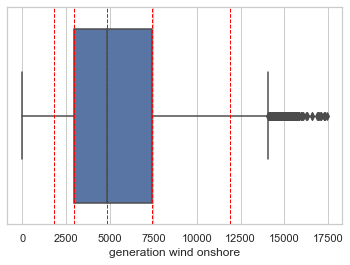

In [180]:
ax = sns.boxplot(x=gwo_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

,sumsquare_error,aic,bic,kl_div
gamma,4.405781e-09,2083.417095,-1.041554e+06,inf
rayleigh,1.883992e-08,2109.347011,-9.906148e+05,inf
chi2,3.202847e-08,2136.671004,-9.719978e+05,inf
norm,5.198683e-08,2150.730376,-9.550245e+05,inf
cauchy,7.204375e-08,2123.218054,-9.435837e+05,inf


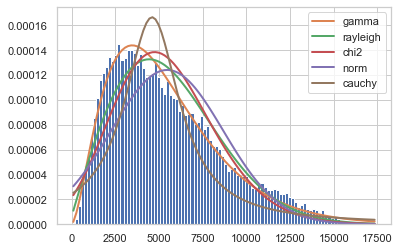

In [181]:
f1 = Fitter(gwo_data, distributions=get_common_distributions())

f1.fit()
f1.summary()

In [182]:
f1.get_best(method = 'sumsquare_error')

{'gamma': {'a': 2.7381722406202487,
  'loc': -24.243996523196554,
  'scale': 2004.5210079806645}}

,sumsquare_error,aic,bic,kl_div
johnsonsb,1.860430e-09,2105.384113,-1.071773e+06,inf
skewnorm,2.338700e-09,2085.862554,-1.063761e+06,inf
erlang,4.405781e-09,2083.417094,-1.041554e+06,inf
gamma,4.405781e-09,2083.417095,-1.041554e+06,inf
geninvgauss,4.405851e-09,2085.419684,-1.041543e+06,inf


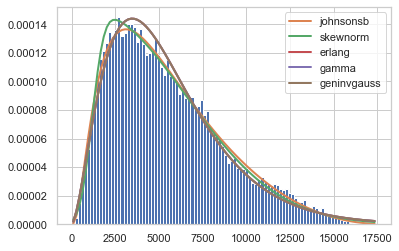

In [183]:
# 'beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 
# 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', moyal', 'nakagami', 'skewnorm'
f2 = Fitter(gwo_data, distributions=['beta', 'betaprime', 'burr', 'erlang', 'exponnorm', 'exponpow', 'f', 'gamma', 'geninvgauss', 'gausshyper', 'genlogistic', 'gumbel_r', 'invgamma', 'johnsonsb', 'kstwobign', 'maxwell', 'moyal', 'nakagami', 'skewnorm'])
f2.fit()
f2.summary()

In [184]:
f2.get_best(method = 'sumsquare_error')

{'johnsonsb': {'a': 1.1422162115146333,
  'b': 1.0876604758305546,
  'loc': -51.65726804772367,
  'scale': 19024.14356495395}}

## Maximum likelihood and Least squares method

In [185]:
params_ml_gwo_gamma = st.gamma.fit(gwo_data)

In [186]:
def loss_for_least_squares_gamma(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gwo_data, q)
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gwo_gamma = least_squares(loss_for_least_squares_gamma, (1.0, 1.0, 1.0))['x']

In [187]:
print(f'Maximum likelihood results: {params_ml_gwo_gamma}')
print(f'Least squares method results: {params_ls_gwo_gamma}')

Maximum likelihood results: (2.7381722406202487, -24.243996523196554, 2004.5210079806645)
Least squares method results: [   2.67896881 -101.08565702 2104.85261596]


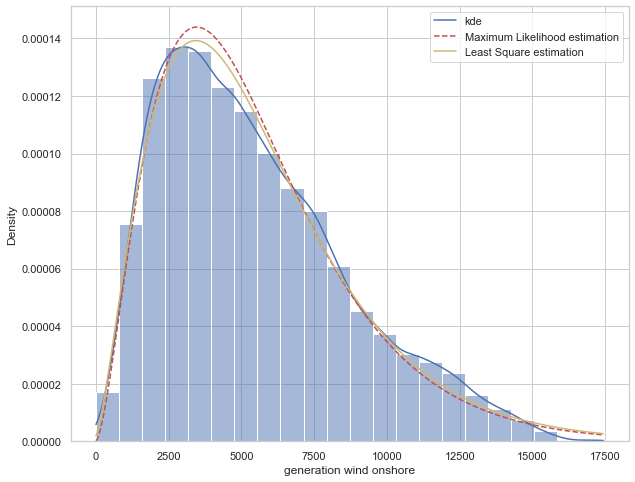

In [188]:
plt.figure(figsize=(10, 8))

sns.histplot(gwo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')

pdf_ml_gwo_gamma = st.gamma.pdf(x, *params_ml_gwo_gamma) 
pdf_ls_gwo_gamma = st.gamma.pdf(x, *params_ls_gwo_gamma)

plt.plot(x, pdf_ml_gwo_gamma, 'r--')
plt.plot(x, pdf_ls_gwo_gamma, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

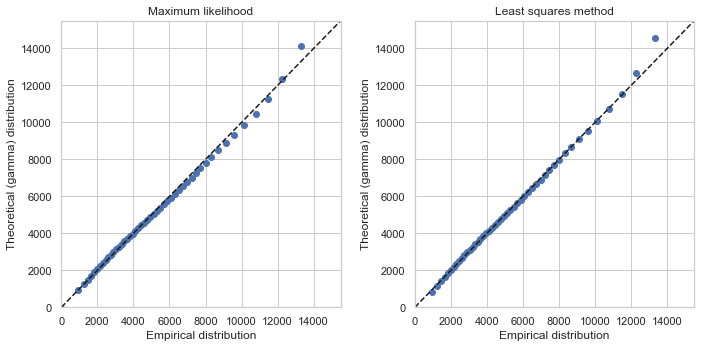

In [189]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gwo_data, percs)

qn_gamma_ml = st.gamma.ppf(percs / 100.0, *params_ml_gwo_gamma)
qn_gamma_ls = st.gamma.ppf(percs / 100.0, *params_ls_gwo_gamma)

ax1.plot(qn_first, qn_gamma_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (gamma) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 15500)
ax1.set_ylim(0, 15500)

ax2.plot(qn_first, qn_gamma_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (gamma) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 15500)
ax2.set_ylim(0, 15500)

plt.tight_layout()

In [190]:
ks_ml = st.kstest(gwo_data, 'gamma', params_ml_gwo_gamma)
cm_ml = scipy.stats.cramervonmises(gwo_data, 'gamma', params_ml_gwo_gamma)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.018142481996139437, pvalue=1.8640521055850942e-10)
CramerVonMisesResult(statistic=3.877186512605061, pvalue=1.0064272748522285e-09)


In [191]:
ks_ls = st.kstest(gwo_data, 'gamma', params_ls_gwo_gamma)
cm_ls = scipy.stats.cramervonmises(gwo_data, 'gamma', params_ls_gwo_gamma)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.014192518778453622, pvalue=1.4519952865901536e-06)
CramerVonMisesResult(statistic=1.2674875891384325, pvalue=0.0005886119025262371)


In [192]:
params_ml_gwo_johnsonsb = st.johnsonsb.fit(gwo_data)

In [193]:
def loss_for_least_squares_johnsonsb(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gwo_data, q)
    quantiles_approx = st.johnsonsb.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gwo_johnsonsb = least_squares(loss_for_least_squares_johnsonsb, (1.0, 1.0, 1.0, 1.0))['x']

In [194]:
print(f'Maximum likelihood results: {params_ml_gwo_johnsonsb}')
print(f'Least squares method results: {params_ls_gwo_johnsonsb}')

Maximum likelihood results: (1.1422162115146333, 1.0876604758305546, -51.65726804772367, 19024.14356495395)
Least squares method results: [ 1.46071649e+00  1.17313496e+00 -1.54512783e+02  2.23314202e+04]


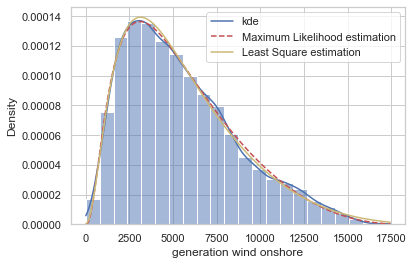

In [195]:
sns.histplot(gwo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation wind onshore')

pdf_ml_gwo_johnsonsb = st.johnsonsb.pdf(x, *params_ml_gwo_johnsonsb) 
pdf_ls_gwo_johnsonsb = st.johnsonsb.pdf(x, *params_ls_gwo_johnsonsb)

plt.plot(x, pdf_ml_gwo_johnsonsb, 'r--')
plt.plot(x, pdf_ls_gwo_johnsonsb, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

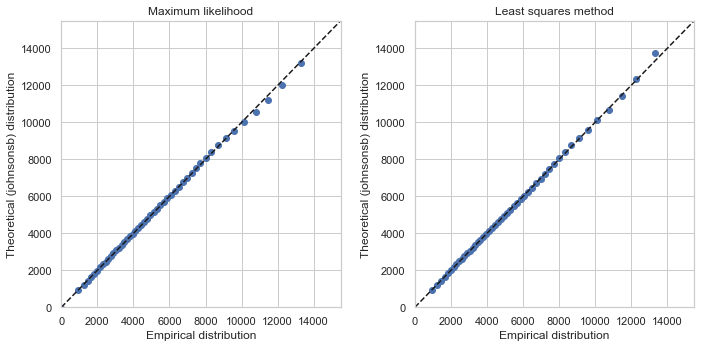

In [196]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gwo_data, percs)

qn_johnsonsb_ml = st.johnsonsb.ppf(percs / 100.0, *params_ml_gwo_johnsonsb)
qn_johnsonsb_ls = st.johnsonsb.ppf(percs / 100.0, *params_ls_gwo_johnsonsb)

ax1.plot(qn_first, qn_johnsonsb_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (johnsonsb) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(0, 15500)
ax1.set_ylim(0, 15500)

ax2.plot(qn_first, qn_johnsonsb_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (johnsonsb) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(0, 15500)
ax2.set_ylim(0, 15500)

plt.tight_layout()


In [197]:
ks_ml = st.kstest(gwo_data, 'johnsonsb', params_ml_gwo_johnsonsb)
cm_ml = scipy.stats.cramervonmises(gwo_data, 'johnsonsb', params_ml_gwo_johnsonsb)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.007733720579730319, pvalue=0.030003916051986046)
CramerVonMisesResult(statistic=0.413745921555527, pvalue=0.06647110669378131)


In [198]:
ks_ls = st.kstest(gwo_data, 'johnsonsb', params_ls_gwo_johnsonsb)
cm_ls = scipy.stats.cramervonmises(gwo_data, 'johnsonsb', params_ls_gwo_johnsonsb)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.00653084070902088, pvalue=0.10001528138500149)
CramerVonMisesResult(statistic=0.26103993969608896, pvalue=0.17481467157148112)


---

# Generation fossil oil

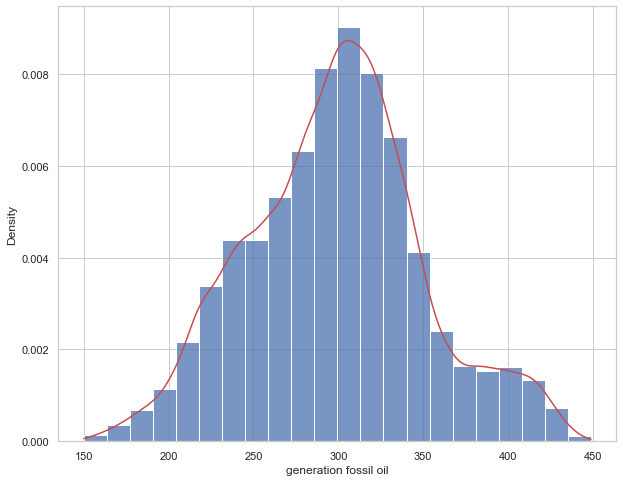

In [199]:
plt.figure(figsize=(10, 8))
gfo_data = energy_data_subsample_clear['generation fossil oil']

gfo_data = gfo_data.loc[(gfo_data >= 150) & (gfo_data < 500)]

kernel = st.gaussian_kde(gfo_data)
print(kernel)

min_amount, max_amount = gfo_data.min(), gfo_data.max()
x = np.linspace(min_amount, max_amount, len(gfo_data))

kde_values = kernel(x)


sns.histplot(gfo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')

In [200]:
gfo_descr = gfo_data.describe()

print(gfo_descr)

count    35015.000000
mean       298.563761
std         52.117710
min        150.000000
25%        263.000000
50%        300.000000
75%        330.000000
max        449.000000
Name: generation fossil oil, dtype: float64


In [201]:
quant = gfo_data.quantile([.1, .25, .5, .75, .95])

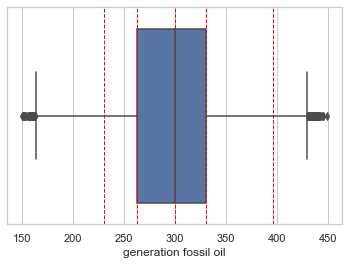

In [202]:
ax = sns.boxplot(x=gfo_data)
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1, color='red')
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1, color='red')

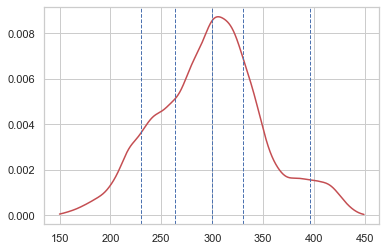

In [203]:
plt.plot(x, kde_values, color='r')
plt.axvline(x=quant[0.10], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.25], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.50], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.75], linestyle='--', linewidth=1)
plt.axvline(x=quant[0.95], linestyle='--', linewidth=1)

,sumsquare_error,aic,bic,kl_div
norm,0.000057,1252.776177,-708823.433163,0.027247
lognorm,0.000060,1255.893029,-706904.185175,0.026328
gamma,0.000060,1255.938255,-706804.794459,0.026347
chi2,0.000068,1259.717079,-702331.956142,0.027321
cauchy,0.000121,1273.020059,-682171.148858,0.060421


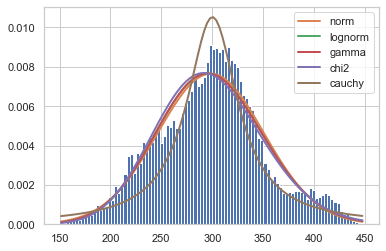

In [204]:
f1 = Fitter(gfo_data, distributions=get_common_distributions())

f1.fit()
f1.summary()

In [205]:
f1.get_best(method = 'sumsquare_error')

{'norm': {'loc': 298.5637605594178, 'scale': 52.11696586793485}}

,sumsquare_error,aic,bic,kl_div
logistic,0.000046,1251.184351,-716424.475039,0.025622
hypsecant,0.000049,1250.523340,-714194.698762,0.027778
gennorm,0.000049,1253.515472,-713815.416364,0.025206
genlogistic,0.000052,1253.299500,-711515.124414,0.025890
exponnorm,0.000056,1255.356748,-708867.103674,0.026172


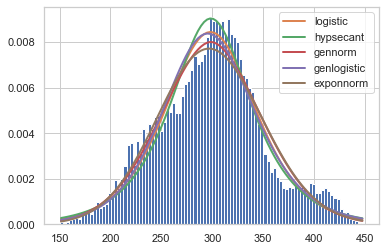

In [206]:
# 'alpha', 'beta', 'betaprime', 'burr', 'burr12', 'chi', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'f', 'fisk', 'foldnorm', 'genlogistic', 'gennorm', 'genextreme', 'gengamma', 'gamma', 'hypsecant', 'logistic', 'powernorm', 'skewnorm'
f2 = Fitter(gfo_data, distributions=['alpha', 'beta', 'betaprime', 'burr','chi', 'chi2', 'crystalball', 'erlang', 'exponnorm', 'f', 'fisk', 'foldnorm', 'genlogistic', 'gennorm', 'genextreme', 'gengamma', 'gamma', 'hypsecant', 'logistic', 'powernorm', 'skewnorm'])
f2.fit()
f2.summary()

In [207]:
f2.get_best(method = 'sumsquare_error')

{'logistic': {'loc': 298.24718441318146, 'scale': 29.610630636102183}}

## Maximum likelihood and Least squares method

In [208]:
params_ml_gfo_norm = st.norm.fit(gfo_data)

In [209]:
def loss_for_least_squares_norm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gfo_data, q)
    quantiles_approx = st.norm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gfo_norm = least_squares(loss_for_least_squares_norm, (1.0, 1.0))['x']

In [210]:
print(f'Maximum likelihood results: {params_ml_gfo_norm}')
print(f'Least squares method results: {params_ls_gfo_norm}')

Maximum likelihood results: (298.5637605594178, 52.11696586793485)
Least squares method results: [298.27720977  51.70354781]


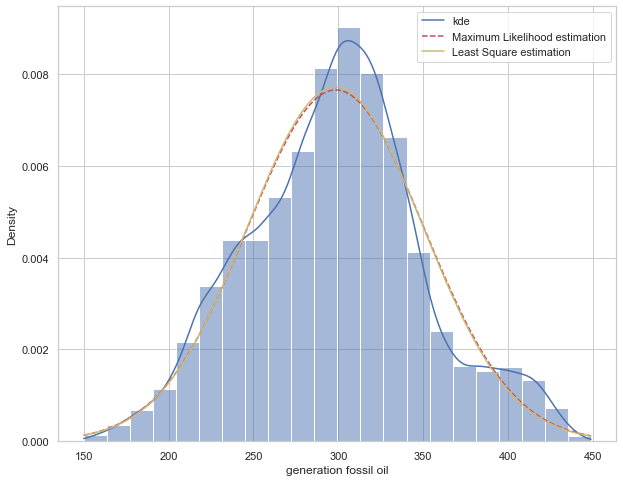

In [211]:
plt.figure(figsize=(10, 8))

sns.histplot(gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf_ml_gfo_norm = st.norm.pdf(x, *params_ml_gfo_norm) 
pdf_ls_gfo_norm = st.norm.pdf(x, *params_ls_gfo_norm)

plt.plot(x, pdf_ml_gfo_norm, 'r--')
plt.plot(x, pdf_ls_gfo_norm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

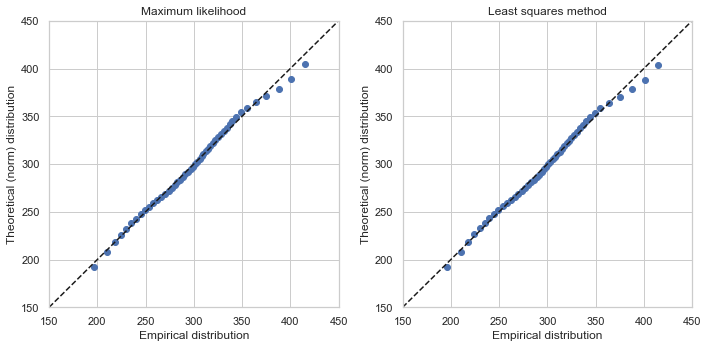

In [212]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data, percs)

qn_norm_ml = st.norm.ppf(percs / 100.0, *params_ml_gfo_norm)
qn_norm_ls = st.norm.ppf(percs / 100.0, *params_ls_gfo_norm)

ax1.plot(qn_first, qn_norm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (norm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(150, 450)
ax1.set_ylim(150, 450)

ax2.plot(qn_first, qn_norm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (norm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(150, 450)
ax2.set_ylim(150, 450)

plt.tight_layout()

In [213]:
ks_ml = st.kstest(gfo_data, 'norm', params_ml_gfo_norm)
cm_ml = scipy.stats.cramervonmises(gfo_data, 'norm', params_ml_gfo_norm)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.030229872350693743, pvalue=3.114897823187004e-28)
CramerVonMisesResult(statistic=7.3299707088360435, pvalue=4.683901044799654e-10)


In [214]:
ks_ls = st.kstest(gfo_data, 'norm', params_ls_gfo_norm)
cm_ls = scipy.stats.cramervonmises(gfo_data, 'norm', params_ls_gfo_norm)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.026806598386360347, pvalue=2.7218356366224845e-22)
CramerVonMisesResult(statistic=6.774616882246675, pvalue=1.0202350075871891e-10)


In [215]:
params_ml_gfo_logistic = st.logistic.fit(gfo_data)

In [216]:
def loss_for_least_squares_logistic(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gfo_data, q)
    quantiles_approx = st.logistic.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gfo_logistic = least_squares(loss_for_least_squares_logistic, (1.0, 1.0))['x']

In [217]:
print(f'Maximum likelihood results: {params_ml_gfo_logistic}')
print(f'Least squares method results: {params_ls_gfo_logistic}')

Maximum likelihood results: (298.24718441318146, 29.610630636102183)
Least squares method results: [298.68548903  29.42264556]


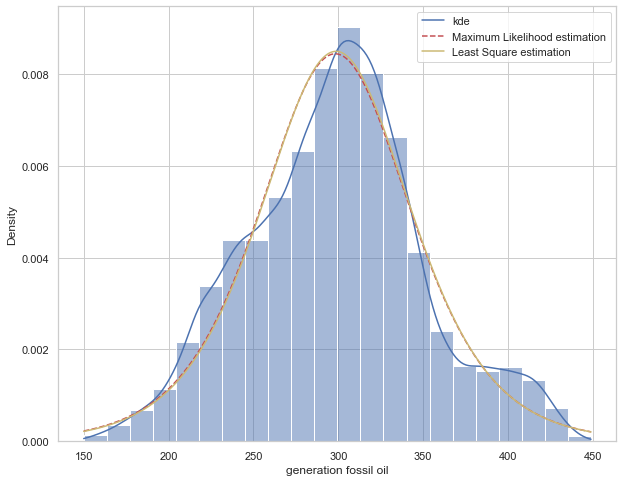

In [218]:
plt.figure(figsize=(10, 8))

sns.histplot(gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf_ml_gfo_logistic = st.logistic.pdf(x, *params_ml_gfo_logistic) 
pdf_ls_gfo_logistic = st.logistic.pdf(x, *params_ls_gfo_logistic)

plt.plot(x, pdf_ml_gfo_logistic, 'r--')
plt.plot(x, pdf_ls_gfo_logistic, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

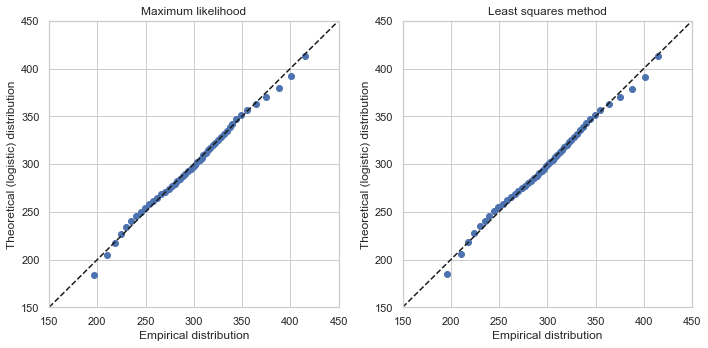

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data, percs)

qn_logistic_ml = st.logistic.ppf(percs / 100.0, *params_ml_gfo_logistic)
qn_logistic_ls = st.logistic.ppf(percs / 100.0, *params_ls_gfo_logistic)

ax1.plot(qn_first, qn_logistic_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (logistic) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(150, 450)
ax1.set_ylim(150, 450)

ax2.plot(qn_first, qn_logistic_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (logistic) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(150, 450)
ax2.set_ylim(150, 450)

plt.tight_layout()

In [220]:
ks_ml = st.kstest(gfo_data, 'logistic', params_ml_gfo_logistic)
cm_ml = scipy.stats.cramervonmises(gfo_data, 'logistic', params_ml_gfo_logistic)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

Maximum likelihood
KstestResult(statistic=0.026239204199223792, pvalue=2.2422964343094666e-21)
CramerVonMisesResult(statistic=4.9303942253753235, pvalue=3.820854743707969e-11)


In [221]:
ks_ls = st.kstest(gfo_data, 'logistic', params_ls_gfo_logistic)
cm_ls = scipy.stats.cramervonmises(gfo_data, 'logistic', params_ls_gfo_logistic)

print('Least squares')
print(ks_ls)
print(cm_ls)

Least squares
KstestResult(statistic=0.029628347923486897, pvalue=3.882635470725765e-27)
CramerVonMisesResult(statistic=5.194407516528444, pvalue=1.0131229188914403e-10)


## Transformation

### Trimming

In [222]:
cutting_gfo_data = cut_ends(gfo_data)

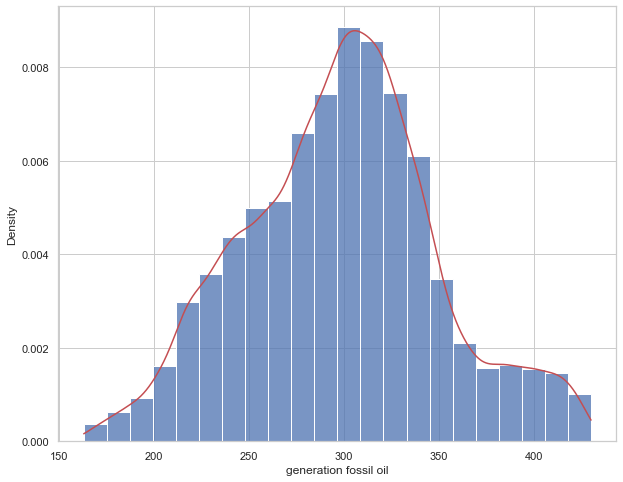

In [224]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(cutting_gfo_data)
print(kernel)

min_amount, max_amount = cutting_gfo_data.min(), cutting_gfo_data.max()
x = np.linspace(min_amount, max_amount, len(cutting_gfo_data))

kde_values = kernel(x)

sns.histplot(cutting_gfo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')


In [225]:
params_ml_gfo_norm = st.norm.fit(cutting_gfo_data)

In [226]:
def loss_for_least_squares_norm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(cutting_gfo_data, q)
    quantiles_approx = st.norm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gfo_norm = least_squares(loss_for_least_squares_norm, (1.0, 1.0))['x']


In [227]:
print(f'Maximum likelihood results: {params_ml_gfo_norm}')
print(f'Least squares method results: {params_ls_gfo_norm}')

Maximum likelihood results: (298.23689114791244, 51.21998792618229)
Least squares method results: [297.99785537  51.02418315]


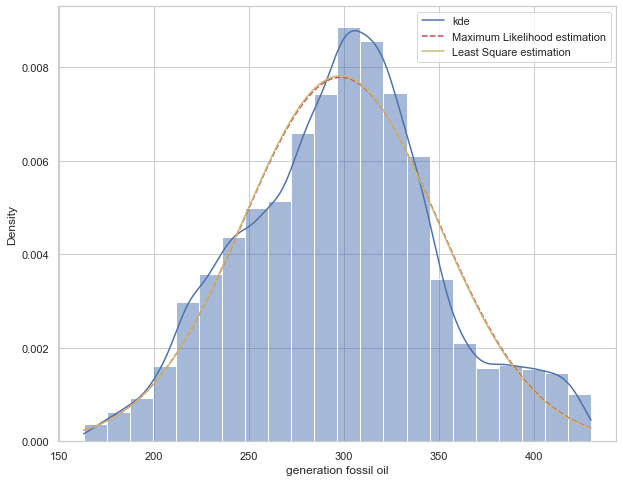

In [228]:
plt.figure(figsize=(10, 8))

sns.histplot(cutting_gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf_ml_gfo_norm = st.norm.pdf(x, *params_ml_gfo_norm) 
pdf_ls_gfo_norm = st.norm.pdf(x, *params_ls_gfo_norm)

plt.plot(x, pdf_ml_gfo_norm, 'r--')
plt.plot(x, pdf_ls_gfo_norm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

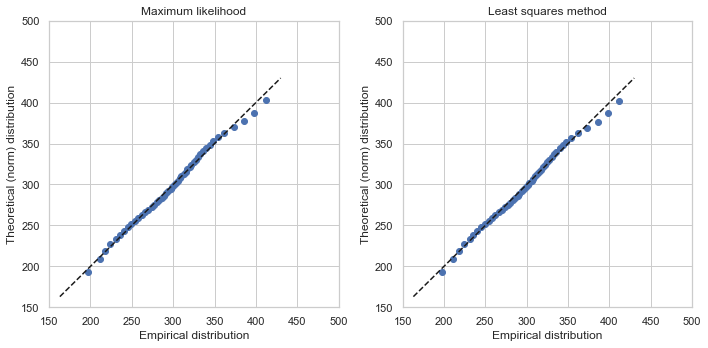

In [229]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gfo_data, percs)

qn_norm_ml = st.norm.ppf(percs / 100.0, *params_ml_gfo_norm)
qn_norm_ls = st.norm.ppf(percs / 100.0, *params_ls_gfo_norm)

ax1.plot(qn_first, qn_norm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (norm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(150, 500)
ax1.set_ylim(150, 500)

ax2.plot(qn_first, qn_norm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (norm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(150, 500)
ax2.set_ylim(150, 500)

plt.tight_layout()

In [230]:
ks_ml = st.kstest(cutting_gfo_data, 'norm', params_ml_gfo_norm)
cm_ml = scipy.stats.cramervonmises(cutting_gfo_data, 'norm', params_ml_gfo_norm)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

ks_ls = st.kstest(cutting_gfo_data, 'norm', params_ls_gfo_norm)
cm_ls = scipy.stats.cramervonmises(cutting_gfo_data, 'norm', params_ls_gfo_norm)

print('Least squares')
print(ks_ls)
print(cm_ls)

Maximum likelihood
KstestResult(statistic=0.02744458688759288, pvalue=3.240242383882594e-23)
CramerVonMisesResult(statistic=6.645798761037362, pvalue=6.909006700084319e-11)
Least squares
KstestResult(statistic=0.025246659229860358, pvalue=1.0344490453619833e-19)
CramerVonMisesResult(statistic=6.466663350974948, pvalue=3.916023061378837e-11)


In [232]:
params_ml_gfo_logistic = st.logistic.fit(cutting_gfo_data)

In [233]:
def loss_for_least_squares_logistic(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(cutting_gfo_data, q)
    quantiles_approx = st.logistic.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gfo_logistic = least_squares(loss_for_least_squares_logistic, (1.0, 1.0))['x']


In [234]:
print(f'Maximum likelihood results: {params_ml_gfo_logistic}')
print(f'Least squares method results: {params_ls_gfo_logistic}')

Maximum likelihood results: (298.0387475426948, 29.194906862646068)
Least squares method results: [298.39922084  29.02678953]


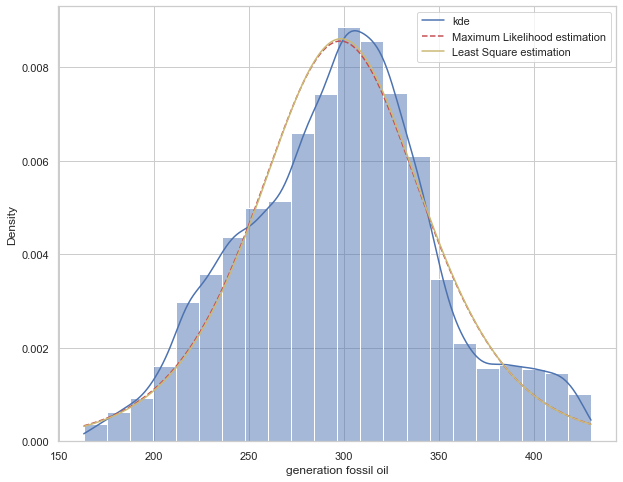

In [236]:
plt.figure(figsize=(10, 8))

sns.histplot(cutting_gfo_data, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf_ml_gfo_logistic = st.logistic.pdf(x, *params_ml_gfo_logistic) 
pdf_ls_gfo_logistic = st.logistic.pdf(x, *params_ls_gfo_logistic)

plt.plot(x, pdf_ml_gfo_logistic, 'r--')
plt.plot(x, pdf_ls_gfo_logistic, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

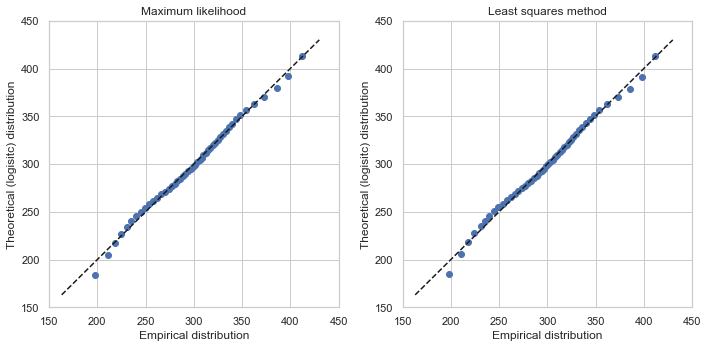

In [238]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(cutting_gfo_data, percs)

qn_logisitc_ml = st.logistic.ppf(percs / 100.0, *params_ml_gfo_logistic)
qn_logisitc_ls = st.logistic.ppf(percs / 100.0, *params_ls_gfo_logistic)

ax1.plot(qn_first, qn_logistic_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (logisitc) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(150, 450)
ax1.set_ylim(150, 450)

ax2.plot(qn_first, qn_logistic_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (logisitc) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(150, 450)
ax2.set_ylim(150, 450)

plt.tight_layout()

In [240]:
ks_ml = st.kstest(cutting_gfo_data, 'logistic', params_ml_gfo_logistic)
cm_ml = scipy.stats.cramervonmises(cutting_gfo_data, 'logistic', params_ml_gfo_logistic)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)

ks_ls = st.kstest(cutting_gfo_data, 'logistic', params_ls_gfo_logistic)
cm_ls = scipy.stats.cramervonmises(cutting_gfo_data, 'logistic', params_ls_gfo_logistic)

print('Least squares')
print(ks_ls)
print(cm_ls)


Maximum likelihood
KstestResult(statistic=0.027884328470941827, pvalue=5.948270624168452e-24)
CramerVonMisesResult(statistic=5.326275742114123, pvalue=1.659344883719882e-10)
Least squares
KstestResult(statistic=0.030795349982003173, pvalue=4.0330610281869784e-29)
CramerVonMisesResult(statistic=5.540618270028578, pvalue=3.551163807458124e-10)


#### Jeo-Johnson

In [242]:
gfo_data_tr = st.yeojohnson(gfo_data, lmbda=0)

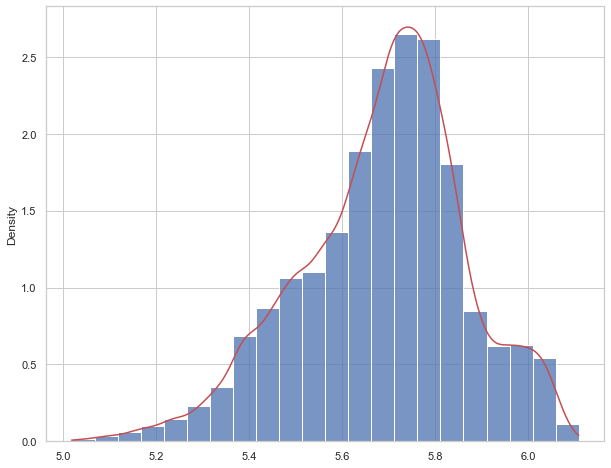

In [243]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(gfo_data_tr)
print(kernel)

min_amount, max_amount = gfo_data_tr.min(), gfo_data_tr.max()
x = np.linspace(min_amount, max_amount, len(gfo_data_tr))

kde_values = kernel(x)

sns.histplot(gfo_data_tr, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')
plt.plot(x, kde_values, color='r')

In [244]:
params_ml_gfo_norm = st.norm.fit(gfo_data_tr)

In [245]:
def loss_for_least_squares_norm(params):
    q = np.linspace(0.01, 0.95)
    quantiles = np.quantile(gfo_data_tr, q)
    quantiles_approx = st.norm.ppf(q, *params)
    return quantiles - quantiles_approx

params_ls_gfo_norm = least_squares(loss_for_least_squares_norm, (1.0, 1.0))['x']

In [246]:
print(f'Maximum likelihood results: {params_ml_gfo_norm}')
print(f'Least squares method results: {params_ls_gfo_norm}')

Maximum likelihood results: (5.686695423316817, 0.17894438863883552)
Least squares method results: [5.68876164 0.18244858]


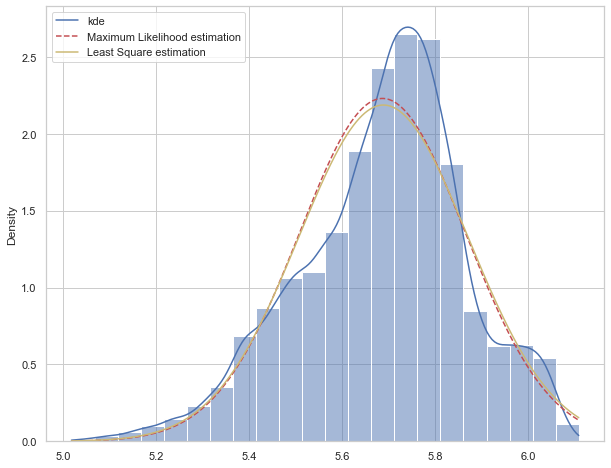

In [247]:
plt.figure(figsize=(10, 8))

sns.histplot(gfo_data_tr, kde=True, bins=int(5 * math.log10(n)), stat='density', label=f'Generation fossil oil')

pdf_ml_gfo_norm = st.norm.pdf(x, *params_ml_gfo_norm) 
pdf_ls_gfo_norm = st.norm.pdf(x, *params_ls_gfo_norm)

plt.plot(x, pdf_ml_gfo_norm, 'r--')
plt.plot(x, pdf_ls_gfo_norm, "y-")
plt.legend(['kde', 'Maximum Likelihood estimation', 'Least Square estimation'])
plt.show()

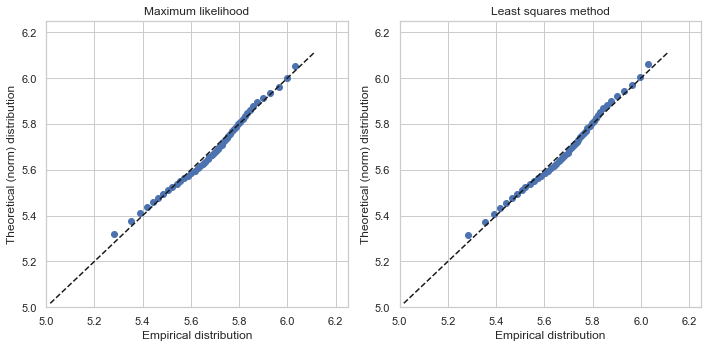

In [251]:
# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data_tr, percs)

qn_norm_ml = st.norm.ppf(percs / 100.0, *params_ml_gfo_norm)
qn_norm_ls = st.norm.ppf(percs / 100.0, *params_ls_gfo_norm)

ax1.plot(qn_first, qn_norm_ml, ls="", marker="o", markersize=6)
ax1.plot(x, x, color="k", ls="--")
ax1.set_xlabel(f'Empirical distribution')
ax1.set_ylabel('Theoretical (norm) distribution')
ax1.set_title('Maximum likelihood')
ax1.set_xlim(5, 6.25)
ax1.set_ylim(5, 6.25)

ax2.plot(qn_first, qn_norm_ls, ls="", marker="o", markersize=6)
ax2.plot(x, x, color="k", ls="--")

ax2.set_xlabel(f'Empirical distribution')
ax2.set_ylabel('Theoretical (norm) distribution')
ax2.set_title('Least squares method')
ax2.set_xlim(5, 6.25)
ax2.set_ylim(5, 6.25)

plt.tight_layout()

In [252]:
ks_ml = st.kstest(gfo_data_tr, 'norm', params_ml_gfo_norm)
cm_ml = scipy.stats.cramervonmises(gfo_data_tr, 'norm', params_ml_gfo_norm)

print('Maximum likelihood')
print(ks_ml)
print(cm_ml)


ks_ls = st.kstest(gfo_data_tr, 'norm', params_ls_gfo_norm)
cm_ls = scipy.stats.cramervonmises(gfo_data_tr, 'norm', params_ls_gfo_norm)

print('Least squares')
print(ks_ls)
print(cm_ls)

Maximum likelihood
KstestResult(statistic=0.05747115369640249, pvalue=5.713606244215706e-101)
CramerVonMisesResult(statistic=28.192652277424163, pvalue=2.216760885964675e-09)
Least squares
KstestResult(statistic=0.053174017267573925, pvalue=1.730634684789754e-86)
CramerVonMisesResult(statistic=26.035136789512517, pvalue=5.802887503847387e-09)


---